# Generate scribbles
This notebook generates scribble drawings for testing purposes

In [180]:
import numpy as np
from shapely.geometry import LineString, MultiLineString
import random
import torch
from torch.utils.data import DataLoader

from countryguess.plotting import _create_figure, _plot_image, plot_sample
from countryguess.utils import normalize_geom
from countryguess.data import geom_to_img, Dataset, TestDataset
from countryguess.model import fetch_model, TripletModel
from countryguess.generate import ValDataset

In [2]:
shape=(96, 96)

In [3]:
def catmull_rom_spline(points, num_points=100):
    """Generate a Catmull-Rom spline"""
    
    def catmull_rom_one_point(p0, p1, p2, p3, t):
        t2 = t * t
        t3 = t2 * t
        f1 = -0.5 * t3 + t2 - 0.5 * t
        f2 = 1.5 * t3 - 2.5 * t2 + 1.0
        f3 = -1.5 * t3 + 2.0 * t2 + 0.5 * t
        f4 = 0.5 * t3 - 0.5 * t2
        x = p0[0] * f1 + p1[0] * f2 + p2[0] * f3 + p3[0] * f4
        y = p0[1] * f1 + p1[1] * f2 + p2[1] * f3 + p3[1] * f4
        return (x, y)
    
    spline = []
    for i in range(len(points) - 3):
        for t in np.linspace(0, 1, num_points):
            spline.append(catmull_rom_one_point(points[i], points[i+1], points[i+2], points[i+3], t))
    
    return spline

In [4]:
def generate_random_scribble(max_num_lines=10, max_points_per_line=8, max_length=40, curve_factor=5):
    """Generate a random scribble consisting of multiple lines"""
    
    num_lines = random.randint(4, max_num_lines)
    
    lines = []
    for _ in range(num_lines):
        num_points = random.randint(4, max_points_per_line)
        points = []
        
        # Start at a random point
        x, y = random.uniform(0, max_length), random.uniform(0, max_length)
        points.append((x, y))
        
        for _ in range(num_points - 1):
            x += random.uniform(-max_length * curve_factor, max_length * curve_factor)
            y += random.uniform(-max_length * curve_factor, max_length * curve_factor)
            points.append((x, y))
        
        # Add extra points to ensure smooth start and end
        points = [points[0]] + points + [points[-1]]
        
        # Generate the Catmull-Rom spline
        spline = catmull_rom_spline(points)
        lines.append(LineString(spline))
    
    return MultiLineString(lines)

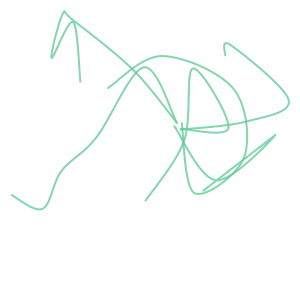

In [148]:
scribble = generate_random_scribble()
scribble

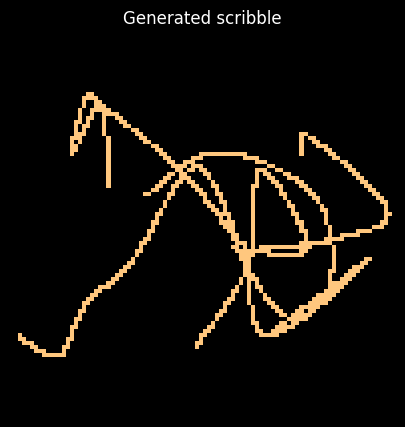

In [149]:
scribble = normalize_geom(scribble, shape=shape)
image = geom_to_img(scribble, shape=shape)

_, axs = _create_figure(1)
_plot_image(axs, image, "Generated scribble")

### Investigate scribbles on modedl

In [85]:
ref_data = Dataset(shape=shape)
val_data = ValDataset(shape=shape, temp=0.9)
val_dl = DataLoader(val_data, batch_size=24, num_workers=2)
test_data = TestDataset(shape=shape)
test_dl = DataLoader(test_data, batch_size=32)

INFO:countryguess.data:Loaded 79 samples from ./data/drawings/


In [76]:
# Load model
model, device = fetch_model("triplet_model")
model.eval()
model.load_reference(ref_data)

INFO:countryguess.model:Fetching model: triplet_model...


INFO:countryguess.model:Loading model...


INFO:countryguess.model:Successfully loaded model


In [103]:
country_names = []
correct_distances = []
incorrect_distances = []

for batch in test_dl:
    drawings = batch["drawing"][:, None, :, :].float().to(device)
    countries, distances = model.get_distance(drawings)

    true_countries = np.array(batch["country_name"])
    ranks = np.where(countries == true_countries[:, None])[1].astype(int)
    batch_indices = np.arange(len(ranks))
    correct_distance = distances[batch_indices, ranks]

    # Mask to get incorrect distances
    mask = np.ones(distances.shape, dtype=bool)
    mask[batch_indices, ranks] = False
    incorrect_distance = distances[mask].reshape(distances.shape[0], -1)

    country_names.extend(batch["country_name"])
    correct_distances.append(correct_distance)
    incorrect_distances.append(incorrect_distance)

test_correct_distances = np.concatenate(correct_distances, axis=0)
test_incorrect_distances = np.concatenate(incorrect_distances, axis=0).flatten()

In [ ]:
# Get distances on validation set
country_names = []
distances = []

for batch in val_dl:
    drawings = batch["drawing"][:, None, :, :].float().to(device)
    countries, distance = model.get_distance(drawings)

    country_names.extend(batch["country_name"])
    distances.append(distance)
    
distances = np.concatenate(distances, axis=0)

In [ ]:
reference_to_generated = np.diag(distances)
generated_to_others = distances[~np.eye(distances.shape[0], dtype=bool)].reshape(distances.shape[0], -1)
generated_to_others = generated_to_others.flatten()

In [77]:
# Get distances on validation set
country_names = []
distances = []

for batch in val_dl:
    drawings = batch["drawing"][:, None, :, :].float().to(device)
    countries, distance = model.get_distance(drawings)

    country_names.extend(batch["country_name"])
    distances.append(distance)
    
distances = np.concatenate(distances, axis=0)

In [78]:
reference_to_generated = np.diag(distances)
generated_to_others = distances[~np.eye(distances.shape[0], dtype=bool)].reshape(distances.shape[0], -1)
generated_to_others = generated_to_others.flatten()

In [110]:
# Get scribble distances
num_scribbles = 20
scribbles = [geom_to_img(normalize_geom(generate_random_scribble(), shape=shape), shape=shape) for _ in range(num_scribbles)]

scribbles = np.array(scribbles)
scribbles = torch.tensor(scribbles[:, None, :, :], dtype=torch.float32).to(device)

scribble_distances = []

with torch.no_grad():
    for i in range(0, num_scribbles, 25):
        batch_scribbles = scribbles[i:i+25]
        _, distances = model.get_distance(batch_scribbles)
        scribble_distances.append(distances)

scribble_distances = np.concatenate(scribble_distances, axis=0)
scribble_to_reference = scribble_distances.flatten()

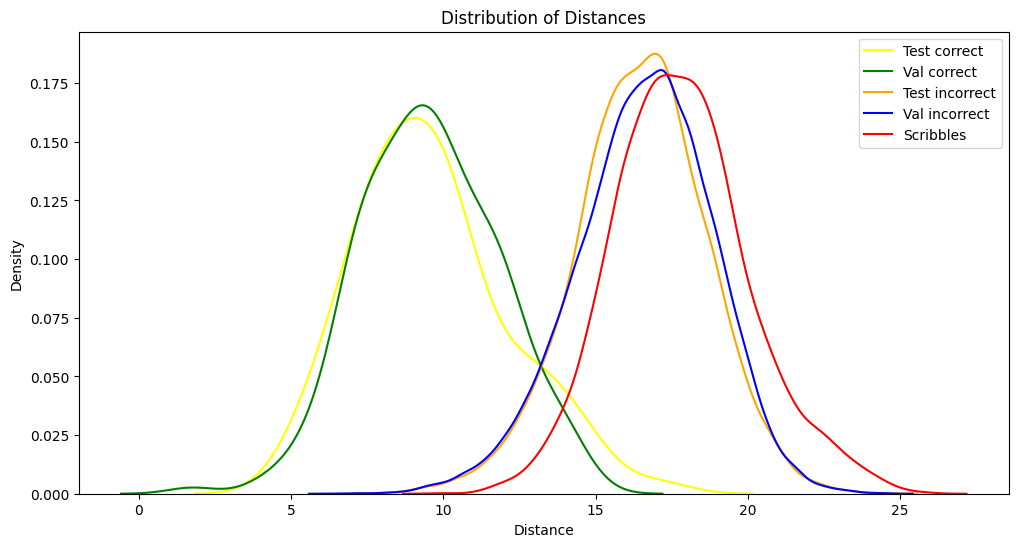

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distributions with KDE lines only
plt.figure(figsize=(12, 6))

sns.kdeplot(test_correct_distances, color='yellow', label='Test correct')
sns.kdeplot(reference_to_generated, color='green', label='Val correct')
sns.kdeplot(test_incorrect_distances, color='orange', label='Test incorrect')
sns.kdeplot(generated_to_others, color='blue', label='Val incorrect')
sns.kdeplot(scribble_to_reference, color='red', label='Scribbles')

plt.xlabel('Distance')
plt.ylabel('Density')
plt.title('Distribution of Distances')
plt.legend()
plt.show()

I need to answer the following question. If I set distance threshold of x, what does the confusion matrix look like?
Scribble/No-scribble. Or a AUC curve.

In [130]:
is_scribble = []
distances = [] # Distance to the closest reference country

In [131]:
# Get scribble distances
num_scribbles = 500
scribbles = [geom_to_img(normalize_geom(generate_random_scribble(), shape=shape), shape=shape) for _ in range(num_scribbles)]

scribbles = np.array(scribbles)
scribbles = torch.tensor(scribbles[:, None, :, :], dtype=torch.float32).to(device)

with torch.no_grad():
    for i in range(0, num_scribbles, 25):
        batch_scribbles = scribbles[i:i+25]
        _, distance = model.get_distance(batch_scribbles)

        distance = np.min(distance, axis=-1)

        distances.extend(distance.tolist())
        is_scribble.extend([True for _ in range(len(distance))])

In [132]:
for batch in test_dl:
    drawings = batch["drawing"][:, None, :, :].float().to(device)
    _, distance = model.get_distance(drawings)

    distance = np.min(distance, axis=-1)

    distances.extend(distance.tolist())
    is_scribble.extend([False for _ in range(len(distance))])

In [135]:
for batch in val_dl:
    drawings = batch["drawing"][:, None, :, :].float().to(device)
    _, distance = model.get_distance(drawings)

    distance = np.min(distance, axis=-1)

    distances.extend(distance.tolist())
    is_scribble.extend([False for _ in range(len(distance))])

In [133]:
from sklearn.metrics import roc_curve, roc_auc_score

In [142]:
# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(is_scribble, distances)

# Compute the AUC
auc = roc_auc_score(is_scribble, distances)
print(f"AUC: {auc:.2f}")

# Compute Youden's J statistic
youden_j = tpr - fpr
optimal_idx = np.argmax(youden_j)
optimal_threshold = thresholds[optimal_idx]
optimal_fpr = fpr[optimal_idx]
optimal_tpr = tpr[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"True Positive Rate (Sensitivity): {optimal_tpr:.2f}")
print(f"False Positive Rate (1 - Specificity): {optimal_fpr:.2f}")

AUC: 0.92
Optimal Threshold: 10.80
True Positive Rate (Sensitivity): 0.91
False Positive Rate (1 - Specificity): 0.18


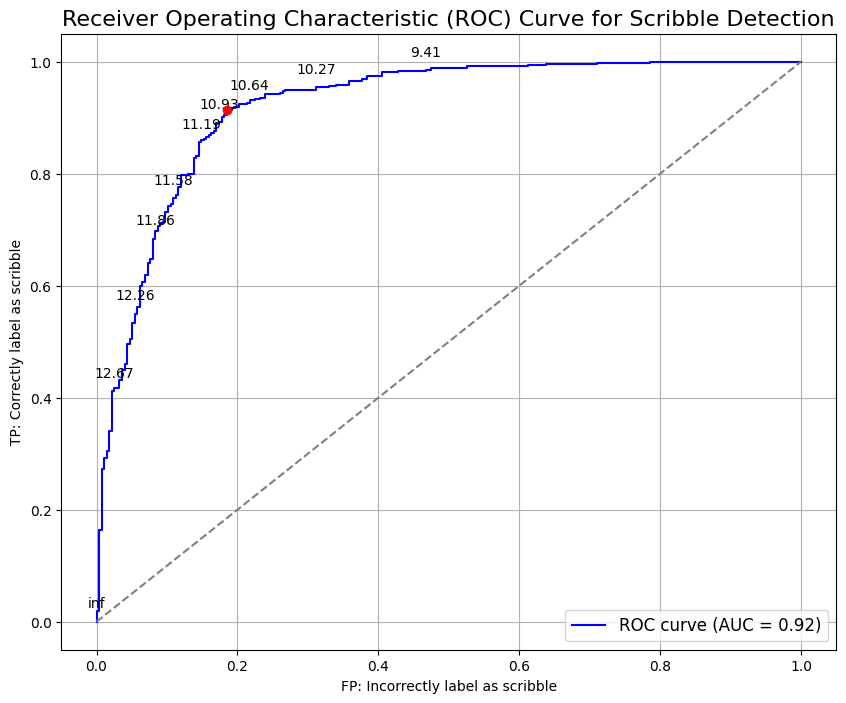

In [146]:
# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') 

# Annotate every nth threshold to avoid clutter
n = 15
for i in range(0, len(thresholds), n):
    plt.annotate(f'{thresholds[i]:.2f}', (fpr[i], tpr[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Annotate the optimal point
plt.scatter([optimal_fpr], [optimal_tpr], color='red', zorder=5)

# Improved axis labels and title
plt.xlabel('FP: Incorrectly label as scribble')
plt.ylabel('TP: Correctly label as scribble')
plt.title('Receiver Operating Characteristic (ROC) Curve for Scribble Detection', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)
plt.show()

### Look at test set distances

In [174]:
countries, distances = [], []

for batch in test_dl:
    drawings = batch["drawing"][:, None, :, :].float().to(device)
    country, distance = model.get_distance(drawings)

    # Sort by distances (ascending order)
    idx = np.argsort(distance, axis=1)
    countries.append(country[idx][:, 0])
    distances.append(np.take_along_axis(distance, idx, axis=1)[:, 0])

countries = np.concatenate(countries)
distances = np.concatenate(distances)

In [265]:
idx = 0
threshold = 12

53
13.092247 True


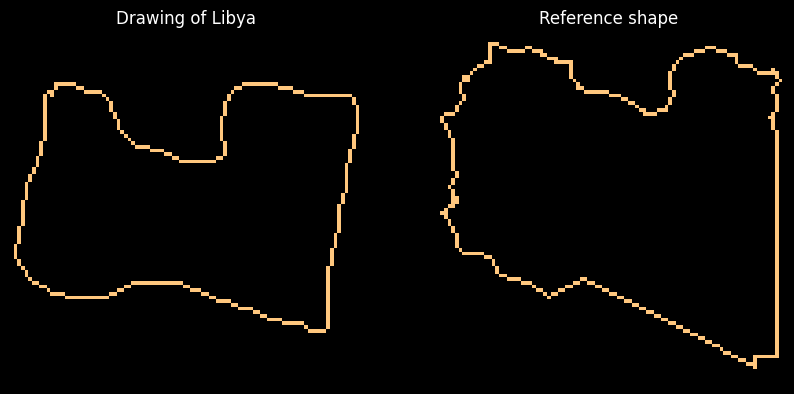

In [319]:
print(idx)
print(distances[idx], distances[idx]>threshold)
plot_sample(test_data, idx=idx)
idx += 1